<a href="https://colab.research.google.com/github/SiddharthMohanty/credit_card_risk_assessment/blob/main/Credit_Risk_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Assessment



Author - Siddharth Mohanty

## Case Study - Overview
This case study focuses on customer default payments in Taiwan. The objective is to perform Exploratory Data Analysis (EDA), apply feature engineering, and develop predictive models to determine the probability of a customer defaulting on their payments. The prediction will assist in identifying high-risk customers and enhancing risk management strategies.


## Project Summary

- **Exploratory Data Analysis (EDA):**  
  Conducted thorough EDA to understand the dataset, identify patterns, detect anomalies, and extract key insights related to customer default behavior.

- **Feature Engineering:**  
  - Created and transformed features to capture important signals such as credit utilization (bill-to-limit ratios) and payment behavior (mean and max payment delays).
  - Applied one-hot encoding to categorical variables to prepare data for modeling.

- **Modeling:**  
  - Developed predictive models to classify whether a customer would default or not. Built and compared three models: Logistic Regression, Random Forest, and XGBoost.  
  - Used k-fold cross-validation for robust model validation and to ensure performance stability across different data splits.  
  - Evaluated models based on metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.  
  - Additionally, performed feature importance analysis to identify which factors have the most influence on the likelihood of default.


## Features List
| Feature Name       | Description |
|--------------------|-------------|
| LIMIT_BAL          | Amount of the given credit (in NT dollars) – includes both individual and family/supplementary credit. |
| SEX                | Gender of the client (1 = male, 2 = female). |
| EDUCATION          | Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others). |
| MARRIAGE           | Marital status (1 = married, 2 = single, 3 = others). |
| AGE                | Age of the client in years. |
| PAY_0              | Repayment status in September (0 = paid in full, 1 = delay 1 month, 2 = delay 2 months, ..., -1 = pay duly). |
| PAY_2              | Repayment status in August (same scale as PAY_0). |
| PAY_3              | Repayment status in July (same scale as PAY_0). |
| PAY_4              | Repayment status in June (same scale as PAY_0). |
| PAY_5              | Repayment status in May (same scale as PAY_0). |
| PAY_6              | Repayment status in April (same scale as PAY_0). |
| BILL_AMT1          | Amount of bill statement in September (NT dollars). |
| BILL_AMT2          | Amount of bill statement in August (NT dollars). |
| BILL_AMT3          | Amount of bill statement in July (NT dollars). |
| BILL_AMT4          | Amount of bill statement in June (NT dollars). |
| BILL_AMT5          | Amount of bill statement in May (NT dollars). |
| BILL_AMT6          | Amount of bill statement in April (NT dollars). |
| PAY_AMT1           | Amount paid in September (NT dollars). |
| PAY_AMT2           | Amount paid in August (NT dollars). |
| PAY_AMT3           | Amount paid in July (NT dollars). |
| PAY_AMT4           | Amount paid in June (NT dollars). |
| PAY_AMT5           | Amount paid in May (NT dollars). |
| PAY_AMT6           | Amount paid in April (NT dollars). |
| default payment next month | Target variable (1 = default, 0 = no default). |


In [1]:
!pip install ucimlrepo

In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

In [4]:
# concatenating X and y in one data frame
df_risk = pd.concat([X, y], axis=1)
column_list = default_of_credit_card_clients.variables['description'].values[1:]
df_risk.columns = column_list
display(df_risk.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## EDA - Understanding Data & Feature Engineering

In [5]:
df_risk.shape

(30000, 24)

In [6]:
display(df_risk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

None

In [7]:
# Renaming PAY_0 to PAY_1 to maintain consistency among other columns
df_risk.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)

In [8]:
# Defining Constants
TARGET = 'default payment next month'
CATEGORICAL_COLS = ['SEX','EDUCATION','MARRIAGE']
NUMERICAL_COLS = ['LIMIT_BAL','AGE'] + [f'BILL_AMT{i}' for i in range(1,7)] + [f'PAY_AMT{i}' for i in range(1,7)]
PAY_COLS = [f'PAY_{i}' for i in range(1,7)] # Keeping `PAY_COLS` as a separate constant list since these columns contain flags with increasing intensity.

In [9]:
# Getting Unique Values foe each categorical column
print(f"Unique values for {TARGET}: {df_risk[TARGET].unique()}")
for col in CATEGORICAL_COLS:
    print(f"Unique values for {col}: {df_risk[col].unique()}")
for col in PAY_COLS:
    print(f"Unique values for {col}: {df_risk[col].unique()}")

Unique values for default payment next month: [1 0]
Unique values for SEX: [2 1]
Unique values for EDUCATION: [2 1 3 5 4 6 0]
Unique values for MARRIAGE: [1 2 3 0]
Unique values for PAY_1: [ 2 -1  0 -2  1  3  4  8  7  5  6]
Unique values for PAY_2: [ 2  0 -1 -2  3  5  7  4  1  6  8]
Unique values for PAY_3: [-1  0  2 -2  3  4  6  7  1  5  8]
Unique values for PAY_4: [-1  0 -2  2  3  4  5  7  6  1  8]
Unique values for PAY_5: [-2  0 -1  2  3  5  4  7  8  6]
Unique values for PAY_6: [-2  2  0 -1  3  6  4  7  8  5]


- **Unexpected values** found in categorical columns that were not present in the data dictionary:  
  - **Education**: Values `0`, `5`, and `6` are undefined → merged into `4` (**Others**).  
  - **Marriage**: Value `0` is undefined → merged into `3` (**Others**).  
  - **Pay columns**: Values `0` and `-2` are undefined → retained as-is, as these flags may have their own specific meaning.


In [10]:
# Mapping Values for Education and Marriage
df_risk['EDUCATION'] = df_risk['EDUCATION'].map({0:4, 1:1, 2:2, 3:3, 4:4, 5:4, 6:4})
df_risk['MARRIAGE'] = df_risk['MARRIAGE'].map({0:3, 1:1, 2:2, 3:3})

In [11]:
display(df_risk[NUMERICAL_COLS].describe().T)

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
BILL_AMT1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
BILL_AMT2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
BILL_AMT3,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
BILL_AMT4,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0
BILL_AMT5,30000.0,40311.400967,60797.155770,-81334.0,1763.00,18104.5,50190.50,927171.0
BILL_AMT6,30000.0,38871.760400,59554.107537,-339603.0,1256.00,17071.0,49198.25,961664.0
PAY_AMT1,30000.0,5663.580500,16563.280354,0.0,1000.00,2100.0,5006.00,873552.0
PAY_AMT2,30000.0,5921.163500,23040.870402,0.0,833.00,2009.0,5000.00,1684259.0


### Univariate Analysis

#### Missing Values and Duplicates

In [12]:
# Missing values & duplicates
print("Missing values (by column):")
print(df_risk.isnull().sum().sort_values(ascending=False).head(20))
print("Duplicate rows:", df_risk.duplicated().sum())

Missing values (by column):
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
dtype: int64
Duplicate rows: 35


* Dataset contains 30,000 records with **no missing values**, ensuring data completeness.

* **35 duplicate rows detected** (≈ 0.12% of data); retained due to small dataset size and negligible duplication rate.

* Each row represents a unique customer profile, indicating the dataset is structured at the customer level.

In [13]:
# Target overview
target = 'default payment next month'
default_rate = df_risk[target].mean()
print(f"Overall default rate: {default_rate:.4%}  (n={df_risk.shape[0]})")
display(df_risk[target].value_counts(normalize=True))

Overall default rate: 22.1200%  (n=30000)


,proportion
default payment next month,
0,0.7788
1,0.2212


- **Default rate** in the dataset is **22.12%**, indicating a **class imbalance** between default and non-default cases.  
- The **minority class** (defaults) may require **resampling techniques** such as **SMOTE** or **class weighting** to improve model performance.


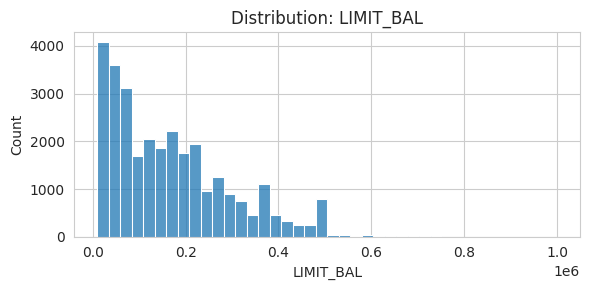

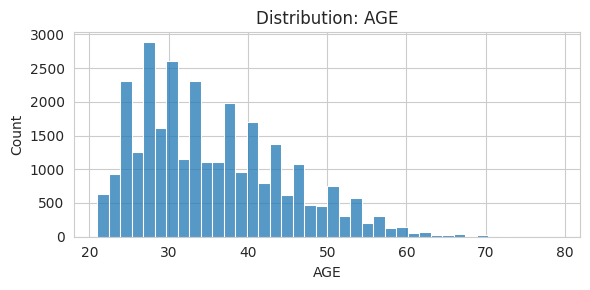

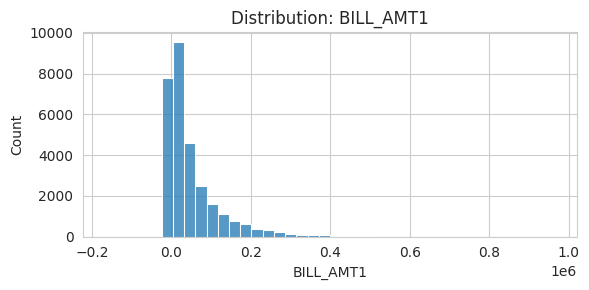

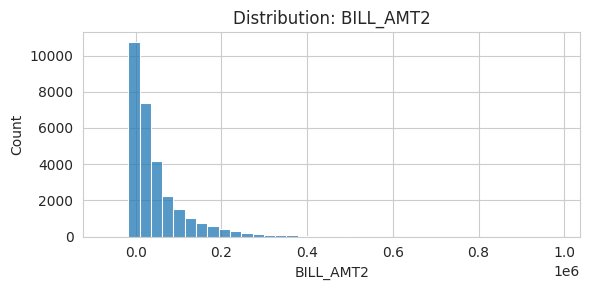

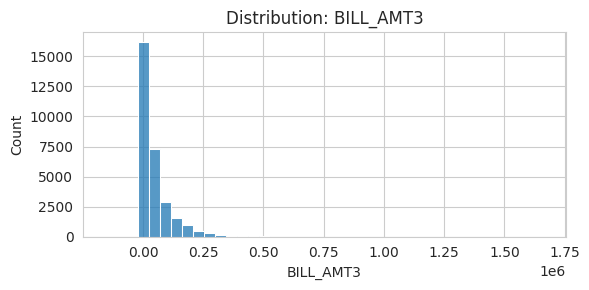

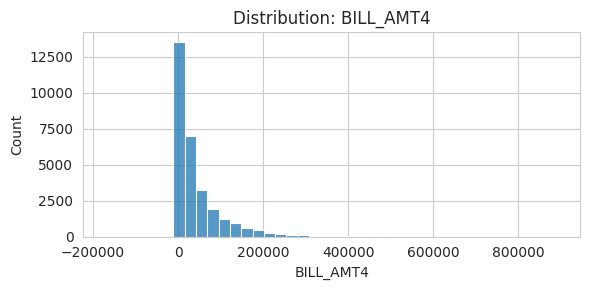

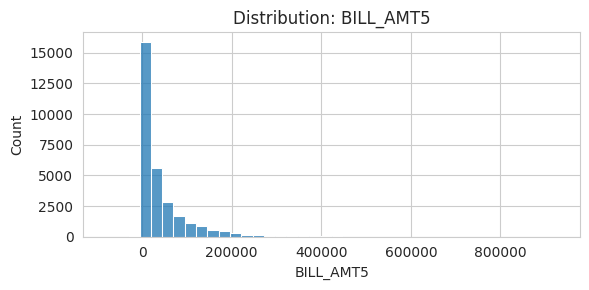

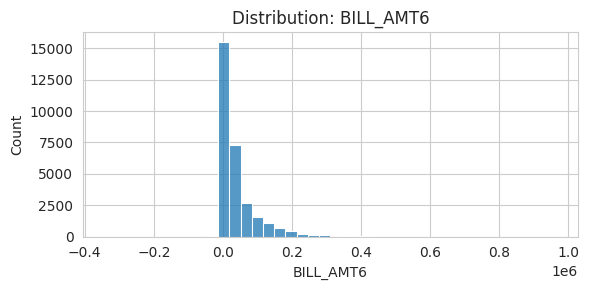

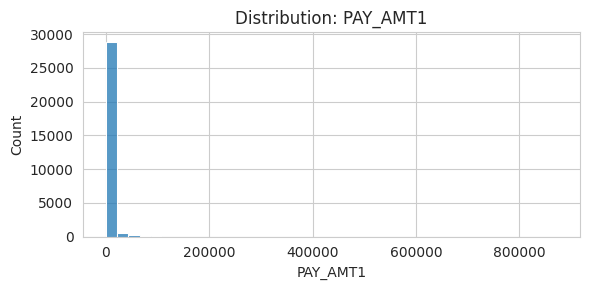

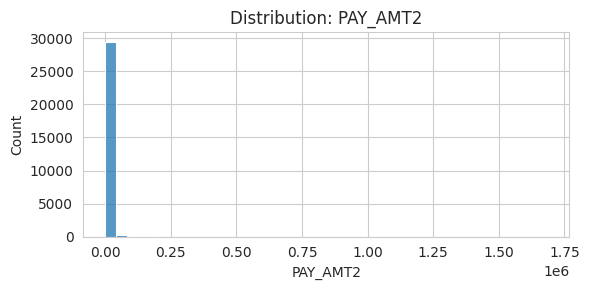

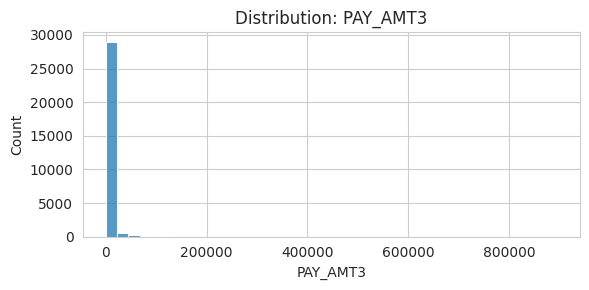

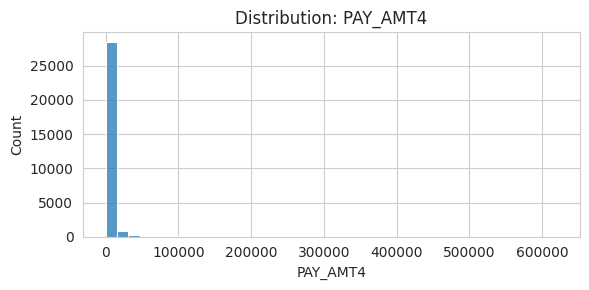

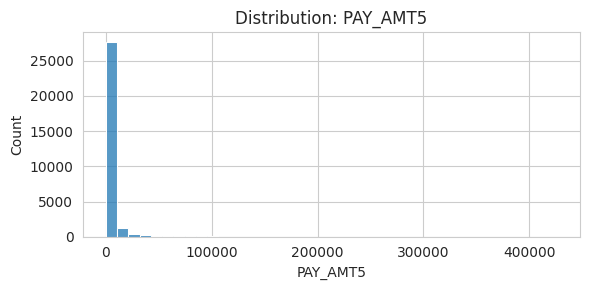

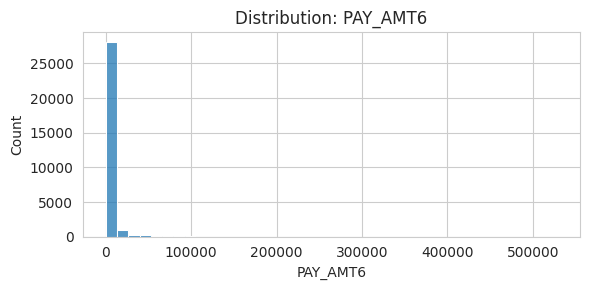

In [14]:
# Univariate numeric distributions
for col in NUMERICAL_COLS:
    plt.figure(figsize=(6,3))
    sns.histplot(df_risk[col].replace([np.inf,-np.inf], np.nan).dropna(), kde=False, bins=40)
    plt.title(f'Distribution: {col}')
    plt.tight_layout()

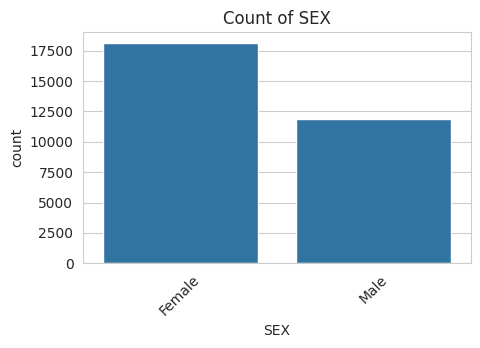

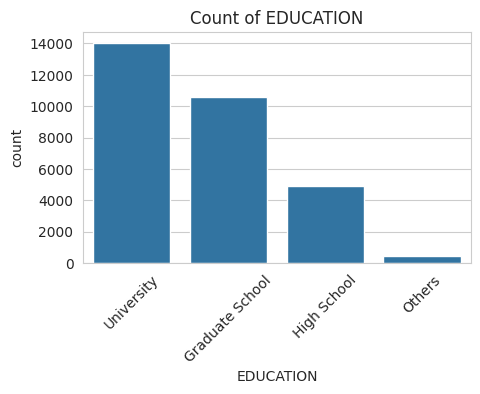

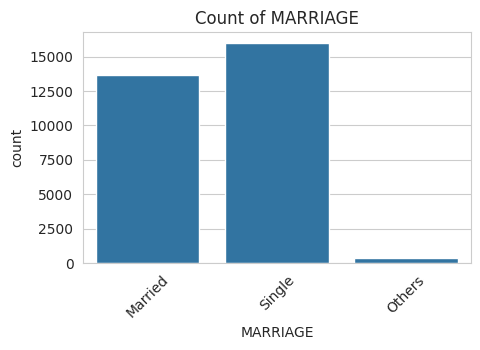

In [15]:
# Categorical analysis
df_cat = df_risk[CATEGORICAL_COLS + [TARGET]].copy()
df_cat['SEX'] = df_cat['SEX'].map({1:'Male', 2:'Female'})
df_cat['EDUCATION'] = df_cat['EDUCATION'].map({1:'Graduate School', 2:'University', 3:'High School', 4:'Others'})
df_cat['MARRIAGE'] = df_cat['MARRIAGE'].map({1:'Married', 2:'Single', 3:'Others'})
for col in CATEGORICAL_COLS:
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df_cat, x=col)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()

### Bivariate Analysis

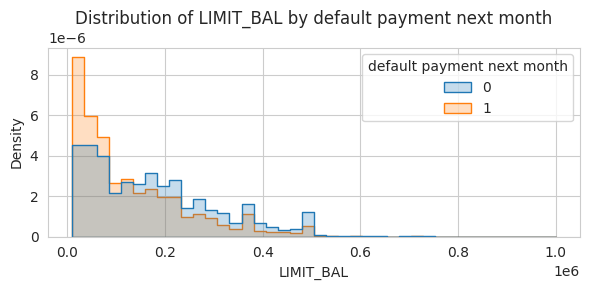

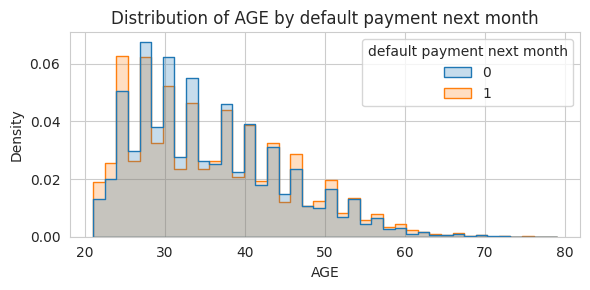

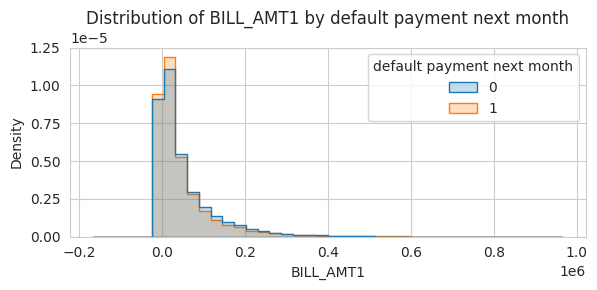

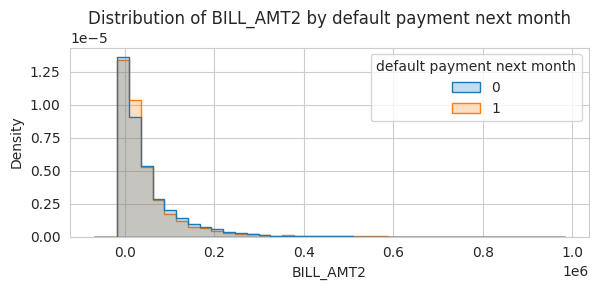

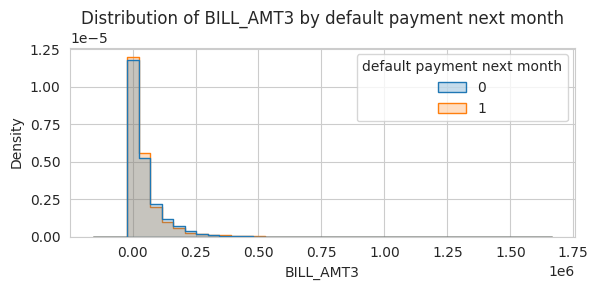

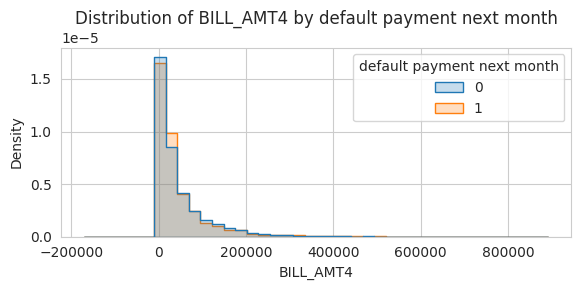

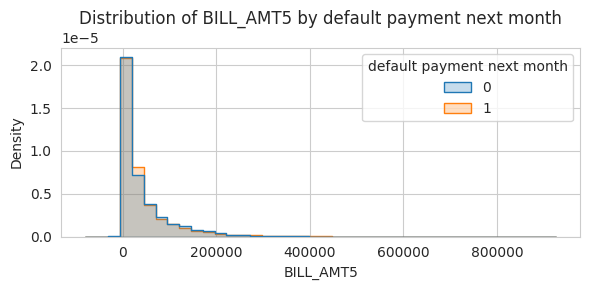

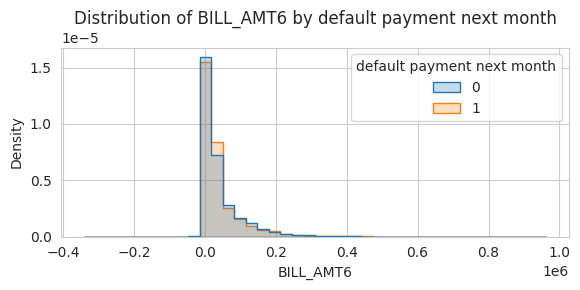

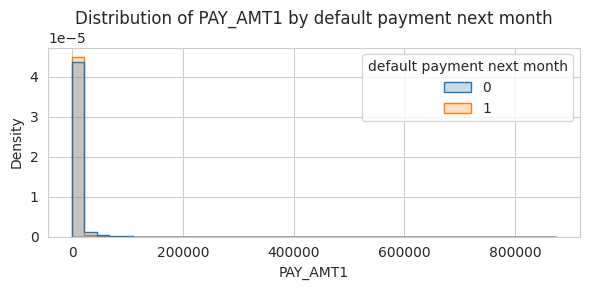

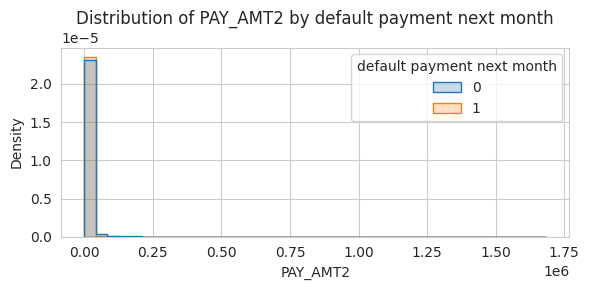

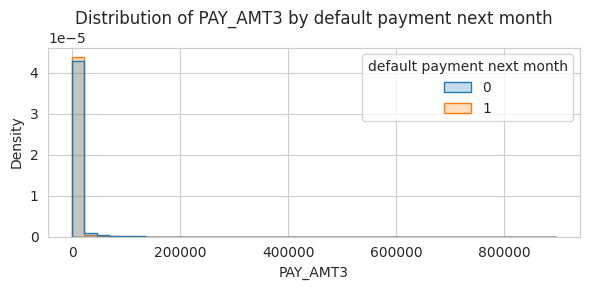

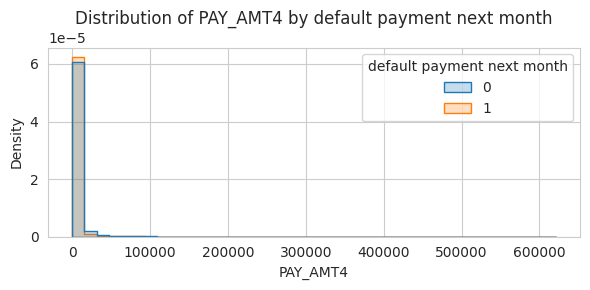

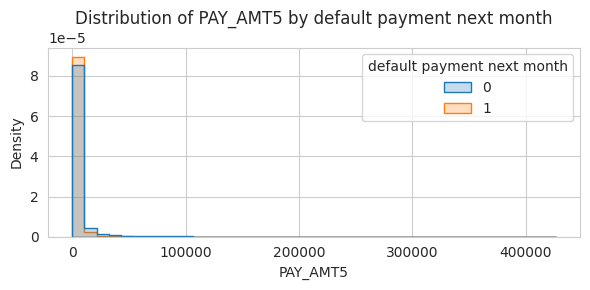

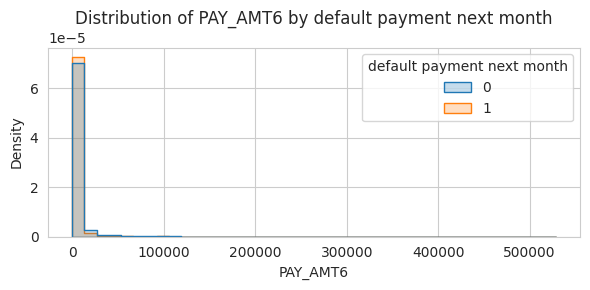

In [16]:
for col in NUMERICAL_COLS:
    plt.figure(figsize=(6,3))
    sns.histplot(
        data=df_risk,
        x=col,
        hue=TARGET,       # color by target variable
        kde=False,
        bins=40,
        element="step",   # outlines instead of filled bars
        stat="density",   # compare shapes instead of absolute counts
        common_norm=False # allow separate scaling per class
    )
    plt.title(f'Distribution of {col} by {TARGET}')
    plt.tight_layout()
    plt.show()


- **Observation from histogram-density plot of `LIMIT_BAL` vs. target variable**:  
  - High density of **defaulters** is concentrated in the **low `LIMIT_BAL`** range.  
  - As `LIMIT_BAL` increases, the proportion of defaulters tends to **decrease**.

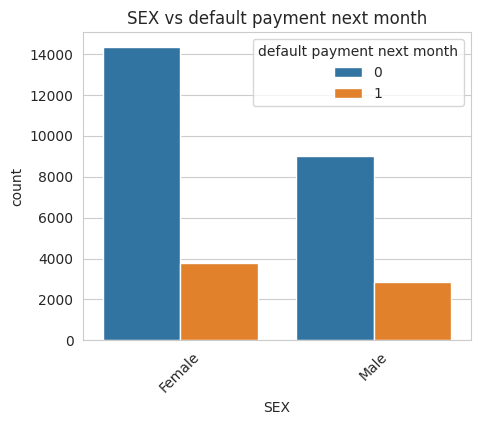

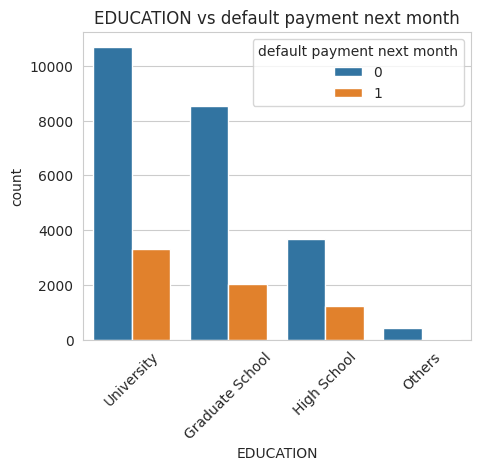

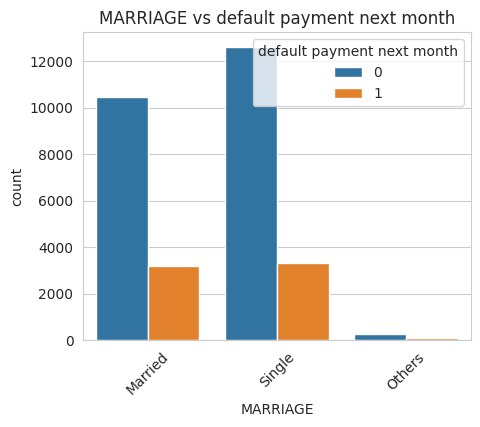

In [17]:
# Categorical column value count with respect to target variable
for col in CATEGORICAL_COLS:
  plt.figure(figsize=(5, 4))
  sns.countplot(data=df_cat, x=col, hue=TARGET)
  plt.title(f'{col} vs {TARGET}')
  plt.xticks(rotation=45)
  plt.show()

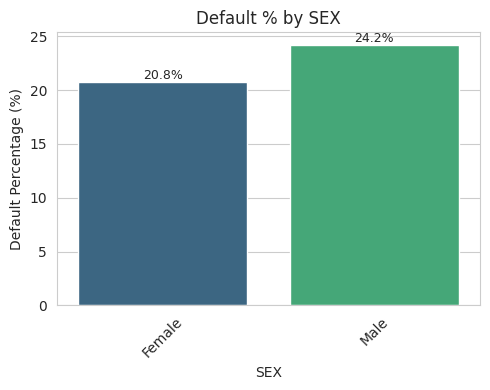

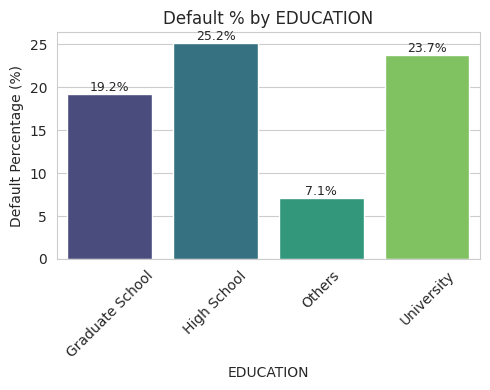

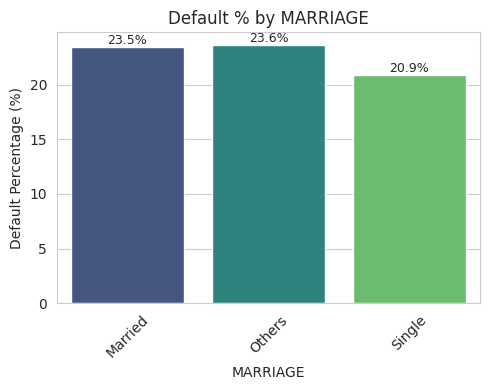

In [18]:
# Default Percentage Per Category
for col in CATEGORICAL_COLS:
    # Calculate default rate per category
    default_rate = (
        df_cat.groupby(col)[TARGET]
        .mean()
        .reset_index()
        .rename(columns={TARGET: 'default_rate'})
    )
    default_rate['default_rate'] *= 100  # convert to %

    plt.figure(figsize=(5,4))
    ax = sns.barplot(
        data=default_rate,
        x=col,
        y='default_rate',
        palette='viridis'
    )
    plt.title(f'Default % by {col}')
    plt.ylabel('Default Percentage (%)')
    plt.xticks(rotation=45)

    # Annotate bars with % values
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

- **Observations from categorical columns**:  
  - **Gender**: Males have a relatively **higher default rate** than females.  
  - **Education**: Individuals studying in **high school** and **university** show **higher default rates** compared to others.  
  - **Marital Status**: **Single** individuals have a **relatively lower default rate** compared to married or other categories.  


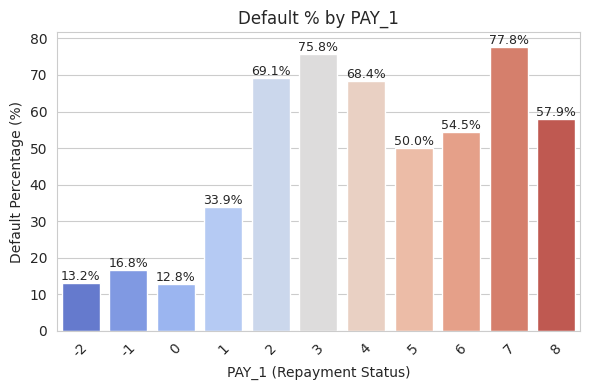

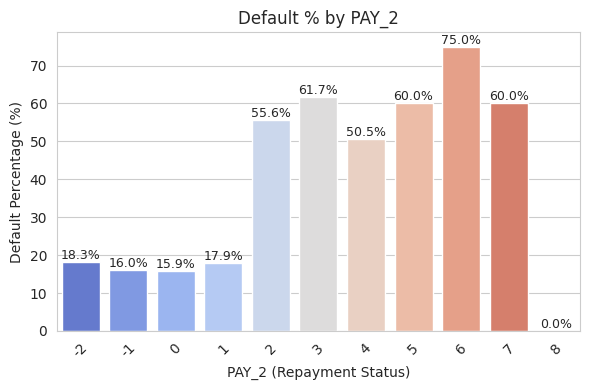

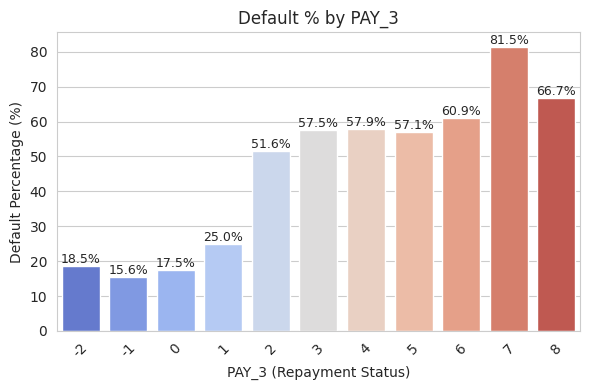

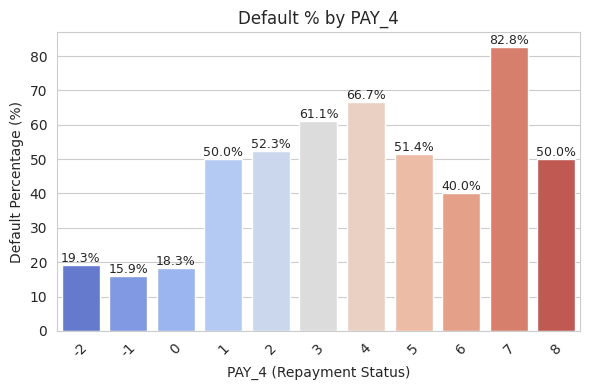

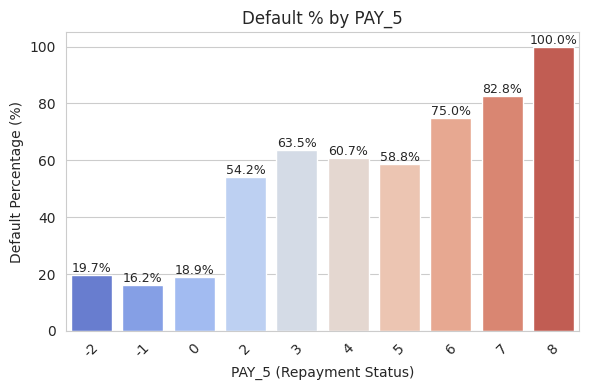

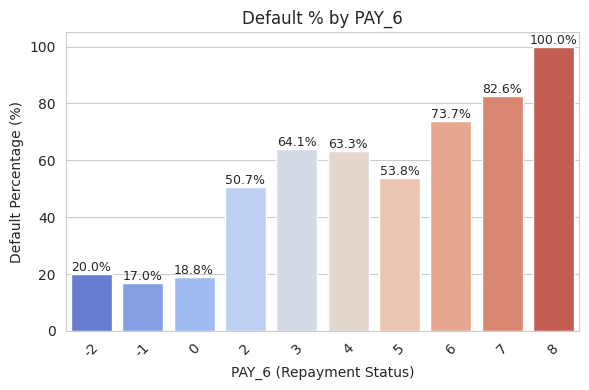

In [19]:
for col in PAY_COLS:
    # Calculate default % for each category in PAY_
    default_rate = (
        df_risk.groupby(col)[target]
        .mean()
        .reset_index()
        .rename(columns={target: 'default_rate'})
    )
    default_rate['default_rate'] *= 100  # convert to %

    plt.figure(figsize=(6,4))
    ax = sns.barplot(
        data=default_rate,
        x=col,
        y='default_rate',
        palette='coolwarm'
    )
    plt.title(f'Default % by {col}')
    plt.ylabel('Default Percentage (%)')
    plt.xlabel(f'{col} (Repayment Status)')
    plt.xticks(rotation=45)

    # Add labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

- **PAY_COLS Analysis (PAY_COL 1–3)**:  
  - A **huge spike** in default rate is observed when moving from **flag 1** to **flag 2** in the histogram plot.  
  - **Interpretation**: This indicates that as the **payment delay** shifts from 1 month late to 2 months late, the **likelihood of default rises sharply**.  
  - Such a sudden jump suggests that **crossing the 2-month delay threshold** may be a **critical tipping point** where repayment chances drop significantly.  


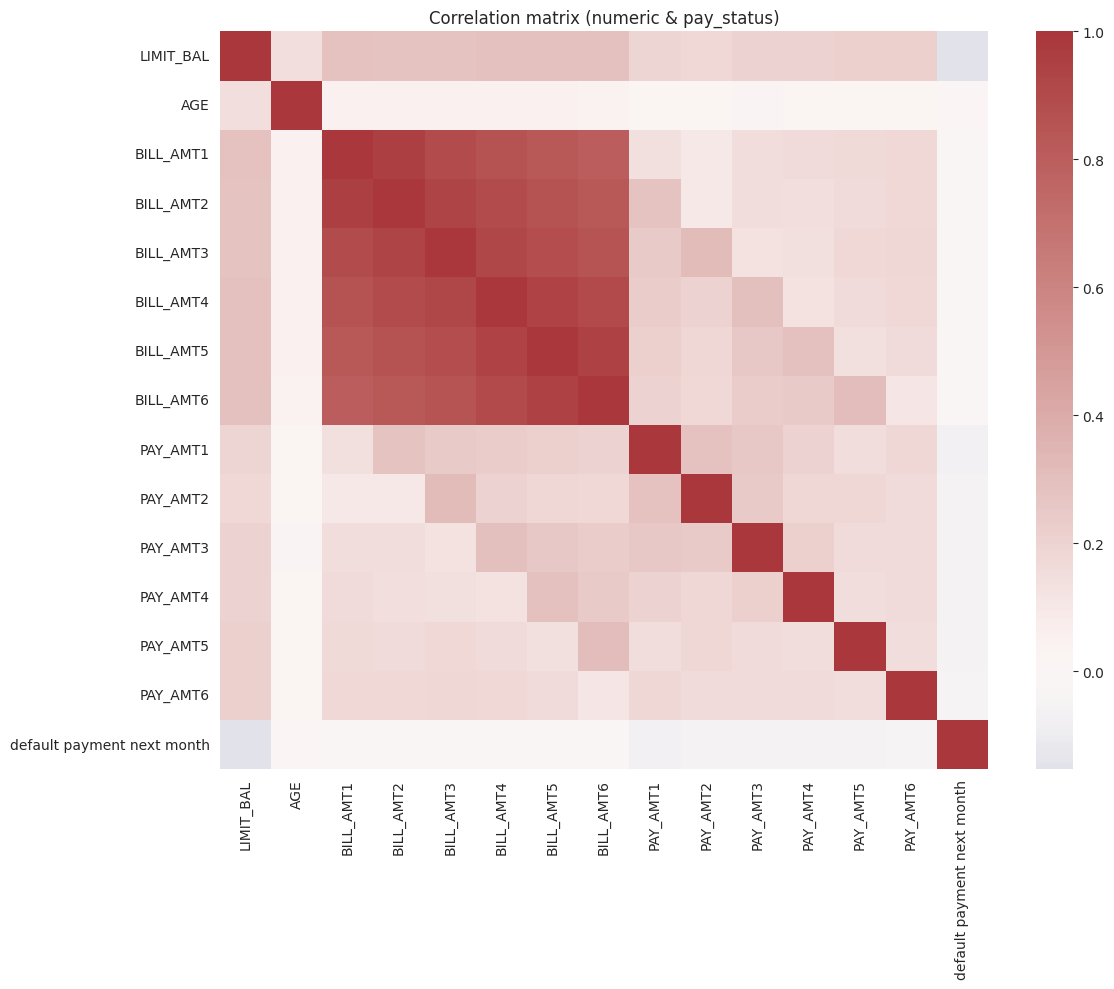

In [20]:
plt.figure(figsize=(12,10))
corr = df_risk[NUMERICAL_COLS+ [TARGET]].corr()
sns.heatmap(corr, cmap='vlag', center=0, annot=False)
plt.title('Correlation matrix (numeric & pay_status)')
plt.tight_layout()

- **Multicollinearity Analysis**:  
  - Overall, there is **not much multicollinearity** observed in the dataset.  
  - The only notable exception is **high correlation among the `BILL_AMT` columns**, which is expected since they represent **bill amounts for consecutive months** and are naturally related.  


In [21]:
# Creating new features - Bill Limit ratio for i th month
for i in range(1,7):
  df_risk[f'bill_limit_ratio_{i}'] = df_risk[f'BILL_AMT{i}'] / df_risk['LIMIT_BAL']
  # df_risk[f'paid_ratio_{i}'] = df_risk[f'PAY_AMT{i}'] / (df_risk[f'BILL_AMT{i}'].replace(0, np.nan))

In [22]:
new_feats = [c for c in df_risk.columns if 'bill_limit_ratio_' in c]
display(df_risk.groupby(target)[new_feats].median().T)

default payment next month,0,1
bill_limit_ratio_1,0.267498,0.492875
bill_limit_ratio_2,0.248595,0.494057
bill_limit_ratio_3,0.225632,0.462710
bill_limit_ratio_4,0.197493,0.406800
bill_limit_ratio_5,0.178423,0.372882
bill_limit_ratio_6,0.154307,0.352116


- **Feature Engineering**:  
  - Created a new feature: **Bill-Limit Ratio** for each month (`Bill_Amt_i / Limit_Bal`).  
  - **Observation**: Across all months, the **median Bill-Limit Ratio** is **higher for default cases** compared to non-default cases.  
    - This indicates that **defaulters tend to utilize a larger portion of their credit limit**, suggesting higher credit utilization could be linked to increased default risk.  


In [23]:
# Created Max delay and mean delay
df_risk['mean_delay'] = df_risk[PAY_COLS].mean(axis=1)
df_risk['max_delay'] = df_risk[PAY_COLS].max(axis=1)

In [24]:
df_risk.groupby(TARGET)["mean_delay"].agg(["mean", "median", "std", "count"])

,mean,median,std,count
default payment next month,,,,
0,-0.330023,0.000000,0.837451,23364
1,0.337176,0.333333,1.243126,6636


In [25]:
df_risk.groupby(TARGET)["max_delay"].agg(["mean", "median", "std", "count"])

,mean,median,std,count
default payment next month,,,,
0,0.201421,0.0,1.186646,23364
1,1.274262,2.0,1.525214,6636


- **Feature Engineering**:  
  - Created two new features from `PAY_COLS` (payment delay flags):  
    1. **mean_delay** – Average delay flag across all months.  
    2. **max_delay** – Maximum delay flag observed across all months.  
  - **Observation**: Both the **mean** and **median** values of `mean_delay` and `max_delay` are **higher for default cases** compared to non-default cases.  
    - This suggests that **more frequent and severe payment delays** are strongly associated with higher default risk.  


- **Feature Engineering**:  
  - Applied **One-Hot Encoding** to transform categorical variables into binary indicator columns.  
  - Each category was converted into a separate column with values `0` or `1`.  
  - **Purpose**: This allows the model to handle categorical data without assuming any ordinal relationship between categories.  


In [26]:
df_risk = pd.get_dummies(df_risk, columns=CATEGORICAL_COLS, drop_first=True)
display(df_risk.head())

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,bill_limit_ratio_5,bill_limit_ratio_6,mean_delay,max_delay,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0.000000,0.000000,-0.333333,2,True,True,False,False,False,False
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0.028792,0.027175,0.500000,2,True,True,False,False,True,False
2,90000,34,0,0,0,0,0,0,29239,14027,...,0.166089,0.172767,0.000000,0,True,True,False,False,True,False
3,50000,37,0,0,0,0,0,0,46990,48233,...,0.579180,0.590940,0.000000,0,True,True,False,False,False,False
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,0.382920,0.382620,-0.333333,0,False,True,False,False,False,False


### Key Insights

1. **PAY_COLS (1–3) Default Rate Spike**  
   - A significant spike in default rate is observed in the histogram from **flag 1 to flag 2** for `PAY_COL1`, `PAY_COL2`, and `PAY_COL3`.  
   - **Interpretation:** This indicates that when the payment delay status shifts from **“1” (one month delay)** to **“2” (two months delay)**, the likelihood of default increases sharply.

2. **Multicollinearity Check**  
   - No significant multicollinearity detected among most features.  
   - **Exception:** Strong correlation is observed among the `BILL_AMT` columns (monthly bill amounts).

3. **Bill Limit Ratio**  
   - New features created: **Bill Limit Ratio** for each month = `BILL_AMT_i / LIMIT_BAL`.  
   - **Observation:** Median value of bill limit ratios is higher for default cases compared to non-default cases **across all months**. This suggests that higher bill-to-limit utilization is associated with greater default risk.

4. **Delay-based Features**  
   - New features created:  
     - `mean_delay` = Average payment delay across months.  
     - `max_delay` = Maximum payment delay across months.  
   - **Observation:** Both the mean and median of these delay metrics are higher for default cases compared to non-default cases, indicating that longer or more frequent delays are linked to higher default risk.

### Feature Engineering Summary

- **Categorical Encoding:**  
  Applied **One-Hot Encoding** for categorical variables to make them suitable for modeling.

- **New Numerical Features:**  
  - **Bill Limit Ratios** for each month (`BILL_AMT_i / LIMIT_BAL`).  
  - **Delay Aggregations** (`mean_delay`, `max_delay`) derived from PAY_COLS.

- **Purpose:**  
  These engineered features capture **credit utilization** and **payment behavior**, both of which show strong association with default probability.


### Challenges Faced in EDA
* Class Imbalance Impact on Insights – Many visualizations were misleading because the majority class dominated the plots, hiding important patterns in the minority class. Stratified sampling can be used for better visualization.

* Unknown Categories in Categorical Columns – Several categorical columns contained values that were not documented in the data dictionary, making it unclear how to interpret them. These “unknown” or unmapped categories created ambiguity and required grouping them under an "Other" category.

## Model Building


### Modelling Approach

Models have been trained using **three algorithms** — **Logistic Regression (LR)**, **Random Forest (RF)**, and **XGBoost (XGB)** — with **two techniques** for handling class imbalance: **Class Weight** and **SMOTE**.

---

#### 1. Class Imbalance Handling
- **Class Weight**: Adjusts the weight of each class in the loss function so the minority class has more influence during training.
- **SMOTE (Synthetic Minority Oversampling Technique)**: Generates synthetic samples of the minority class by interpolating between existing samples, balancing the dataset.

---

#### 2. Model Selection & Justification
- **Logistic Regression (LR)**
  - Used as a **baseline model** because it is simple, interpretable, and a good starting point for binary classification.
  - Applied **StandardScaler** to normalize features so that no feature dominates due to its magnitude.
  - Set **class weight = 'balanced'** to address class imbalance.
  - Tuned hyperparameters using **GridSearchCV** for exhaustive search.

- **Random Forest (RF)** & **XGBoost (XGB)**
  - Chosen for their ability to capture **non-linear relationships** and **feature interactions**.
  - Tuned hyperparameters using **RandomizedSearchCV**, which is faster than exhaustive search.
  - Compared performance with **class weight adjustments** and **SMOTE**.

---

#### 3. Model Evaluation
- **Primary Metric**: **F1 - Score**
  - Chosen for its ability to evaluate the model’s discrimination power across thresholds.
  - Less sensitive to class imbalance compared to accuracy.
- **Additional Metrics**: Accuracy, Recall, Precision.
- **Recall** is emphasized because **False Negatives** (predicting non-default when it’s actually default) are costly in default prediction.

---

#### 4. Validation Strategy
- Used **Stratified K-Fold Cross-Validation** to ensure that each fold has the same proportion of default and non-default cases.
- Provides a more reliable and robust estimate of model performance.



### Consolidated Model Performance Metrics

The following code presents the evaluation metrics for all trained models in a single, easy-to-compare tabular format.

| Model               | ROC-AUC (Best/Grid)      | Accuracy (mean) | Precision (mean) | Recall (mean) | F1 (mean) |
|---------------------|--------------------------|-----------------|------------------|---------------|-----------|
| Logistic Regression | 0.6558                   | 0.5467          | 0.2898           | 0.7229        | 0.4137    |
| XGBoost             | 0.7866                   | 0.7510          | 0.4559           | 0.6453        | 0.5342    |
| Random Forest       | 0.7842                   | 0.7798          | 0.5021           | 0.5841        | 0.5399    |
| XGBoost (SMOTE)     | 0.9179                   | 0.8449          | 0.8800           | 0.7988        | 0.8374    |
| Random Forest(SMOTE)| 0.9343                   | 0.8619          | 0.8827           | 0.8349        | 0.8581    |



In [27]:
def model_validation(best_model, X, y):

  scoring = {
      'accuracy': make_scorer(accuracy_score),
      'precision': make_scorer(precision_score),
      'recall': make_scorer(recall_score),
      'f1': make_scorer(f1_score),
      'roc_auc': make_scorer(roc_auc_score, needs_proba=True)  # needs_proba True for probabilities
  }

  cv_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

  cv_results = cross_validate(best_model, X, y, cv=cv_eval, scoring=scoring, return_train_score=False, n_jobs=-1)

  # Summarize metrics
  def summarize_metric(name):
      vals = cv_results[f'test_{name}']
      print(f"{name.upper():7s}: mean={vals.mean():.4f}  std={vals.std():.4f}")

  print("\nCross-validated performance (5-fold stratified):")
  for metric in ['accuracy','precision','recall','f1']:
    summarize_metric(metric)

  y_pred = cross_val_predict(best_model, X, y, cv=cv_eval, method='predict', n_jobs=-1)
  print("\nConfusion Matrix (cv predictions):")
  print(confusion_matrix(y, y_pred))


### Logistic Regression

In [28]:
def logistic_regression_model(X, y):
  # ------------- Preprocessing pipeline -------------
  numeric_transformer = Pipeline(steps=[
      ('scaler', StandardScaler())
  ])

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, NUMERICAL_COLS),
      ],
      remainder='drop'  # drop any other columns
  )

  # ------------- Classifier pipeline -------------
  # Use class_weight='balanced' to handle imbalance
  clf = LogisticRegression(class_weight='balanced', random_state=42, max_iter=5000)

  pipe = Pipeline(steps=[
      ('preproc', preprocessor),
      ('clf', clf)
  ])

  # ------------- Hyperparameter grid (for GridSearchCV) -------------
  # We search over inverse-regularization parameter C and penalty type.
  # Using solver='saga' supports both l1 and l2; leave solver configured inside classifier via param grid
  param_grid = {
      'clf__C': [0.01, 0.1, 1.0, 10.0],
      'clf__penalty': ['l2', 'l1'],      # saga supports both l1 & l2
      'clf__solver': ['saga'],
  }

  # ------------- Stratified Grid Search -------------
  cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  grid = GridSearchCV(
      estimator=pipe,
      param_grid=param_grid,
      scoring='f1',
      n_jobs=-1,
      cv=cv_outer,
      verbose=1,
      refit=True
  )

  grid.fit(X, y)

  print("Best params:", grid.best_params_)
  print("Best CV F1 Score:", grid.best_score_)

  return grid

In [29]:
df_log_reg = df_risk.copy()
X = df_log_reg.drop(columns=[TARGET])
y = df_log_reg[TARGET].astype(int)
grid_log_reg = logistic_regression_model(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

model_validation(grid_log_reg.best_estimator_, X_scaled_df, y)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Best CV ROC-AUC: 0.4136548200466854

Cross-validated performance (5-fold stratified):
ACCURACY: mean=0.5471  std=0.0083
PRECISION: mean=0.2901  std=0.0061
RECALL : mean=0.7236  std=0.0122
F1     : mean=0.4141  std=0.0080

Confusion Matrix (cv predictions):
[[11610 11754]
 [ 1834  4802]]


In [30]:
def treebased_model(model, params, X, y):
  # Stratified KFold
  cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  grid_search = RandomizedSearchCV(
      estimator=model,
      param_distributions=params,
      scoring='f1',
      n_jobs=-1,
      cv=cv_strategy,
      verbose=1
  )

  # Fit GridSearch
  grid_search.fit(X, y)

  print("Best Hyperparameters:", grid_search.best_params_)
  print("Best F1 score from GridSearch:", grid_search.best_score_)

  return grid_search




### Random Forest - With Class weight

In [31]:
# Features and target
X = df_risk.drop(columns=[target])
y = df_risk[target]

# Random Forest with class_weight
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [None, 2, 5, 10],
    'min_samples_leaf': [None, 1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_rf = treebased_model(rf, param_grid, X, y)
model_validation(grid_rf.best_estimator_, X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
Best ROC-AUC from GridSearch: 0.5426857003159286

Cross-validated performance (5-fold stratified):
ACCURACY: mean=0.7801  std=0.0024
PRECISION: mean=0.5025  std=0.0048
RECALL : mean=0.5836  std=0.0097
F1     : mean=0.5400  std=0.0037

Confusion Matrix (cv predictions):
[[19529  3835]
 [ 2763  3873]]


### XGBoost - With Class Weight
scale_pos_weight tells the algorithm how much more weight to give to positive class examples compared to the negative class.

In [32]:
# Features and target
X = df_risk.drop(columns=[target])
y = df_risk[target]

n_pos = (y == 1).sum()
n_neg = (y == 0).sum()
scale_pos_weight = n_neg / max(1, n_pos)
print(f"Pos: {n_pos}, Neg: {n_neg}, scale_pos_weight: {scale_pos_weight:.3f}")

xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,  # handles imbalance
    verbosity=0
)

param_grid = {
    "learning_rate": [0.05, 0.10, 0.15 ],
    "max_depth": [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

grid_xgb = treebased_model(xgb, param_grid, X, y)
model_validation(grid_xgb.best_estimator_, X, y)

Pos: 6636, Neg: 23364, scale_pos_weight: 3.521
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.3}
Best ROC-AUC from GridSearch: 0.538527567181956

Cross-validated performance (5-fold stratified):
ACCURACY: mean=0.7586  std=0.0046
PRECISION: mean=0.4660  std=0.0071
RECALL : mean=0.6231  std=0.0081
F1     : mean=0.5332  std=0.0031

Confusion Matrix (cv predictions):
[[18623  4741]
 [ 2501  4135]]


### XGBoost with SMOTE

In [33]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X, y)
xgb_smote = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# ---------------- Hyperparameter grid ----------------
param_grid = {
    "learning_rate": [0.05, 0.10, 0.15 ],
    "max_depth": [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

grid_xgb_smote = treebased_model(xgb_smote, param_grid, X_train_res, y_train_res)
model_validation(grid_xgb_smote.best_estimator_, X_train_res, y_train_res)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.4}
Best ROC-AUC from GridSearch: 0.850856976875568

Cross-validated performance (5-fold stratified):
ACCURACY: mean=0.8563  std=0.0042
PRECISION: mean=0.8898  std=0.0074
RECALL : mean=0.8134  std=0.0027
F1     : mean=0.8499  std=0.0039

Confusion Matrix (cv predictions):
[[21010  2354]
 [ 4360 19004]]


### Random Forest With SMOTE

In [ ]:
# Train Random Forest model
rf_model_smote = RandomForestClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [None, 2, 5, 10],
    'min_samples_leaf': [None, 1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_rf_smote = treebased_model(rf_model_smote, param_grid, X_train_res, y_train_res)
model_validation(grid_rf_smote.best_estimator_, X_train_res, y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Fit final model for feature importance
best_rf = grid_rf_smote.best_estimator_
best_rf.fit(X_train_res, y_train_res)

# Feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(feature_importance_df)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.show()

**Mean Delay** in payments has the highest feature importance determining if the customer would default or not.

### Intuitive Analysis of Model Metrics

| Model               | ROC-AUC (Best/Grid)      | Accuracy (mean) | Precision (mean) | Recall (mean) | F1 (mean) |
|---------------------|--------------------------|-----------------|------------------|---------------|-----------|
| Logistic Regression | 0.6558                   | 0.5467          | 0.2898           | 0.7229        | 0.4137    |
| XGBoost             | 0.7866                   | 0.7510          | 0.4559           | 0.6453        | 0.5342    |
| Random Forest       | 0.7842                   | 0.7798          | 0.5021           | 0.5841        | 0.5399    |
| XGBoost (SMOTE)     | 0.9179                   | 0.8449          | 0.8800           | 0.7988        | 0.8374    |
| Random Forest(SMOTE)| 0.9343                   | 0.8619          | 0.8827           | 0.8349        | 0.8581    |


From the table above, we can draw several insights:  

1. **Baseline Performance (Logistic Regression)**  
   - Logistic Regression, used as the baseline, achieves a ROC-AUC of **0.6558** and a high Recall (**0.7229**) but low Precision (**0.2898**).  
   - This indicates that the model identifies most positive cases (low false negatives) but at the cost of more false positives.

2. **Without SMOTE (XGBoost & Random Forest)**  
   - XGBoost (**0.7866 ROC-AUC**) and Random Forest (**0.7842 ROC-AUC**) outperform Logistic Regression in terms of ROC-AUC, Accuracy, and F1 score.  
   - However, both still have moderate Recall (0.6453 and 0.5841), meaning some positives are missed.  
   - Precision is higher than Logistic Regression, indicating better balance between false positives and false negatives.

3. **With SMOTE (XGBoost & Random Forest)**  
   - Applying SMOTE leads to a significant jump in ROC-AUC (**0.9179 for XGBoost** and **0.9343 for Random Forest**), Accuracy, and especially Recall.  
   - Both models now achieve Recall above **0.79**, meaning they capture a much larger proportion of actual positive cases.  
   - Precision also improves drastically (around **0.88**), showing that SMOTE not only helps detect more positives but also reduces false alarms.  
   - This balance between high Recall and high Precision results in strong F1 scores (**0.8374** and **0.8581**).

4. **Key Takeaways**  
   - SMOTE effectively addresses class imbalance, leading to improved detection of minority class cases.  
   - Among all models, **Random Forest with SMOTE** achieves the best overall performance, slightly edging out XGBoost with SMOTE in ROC-AUC, Accuracy, and F1 score.  
   - Given the importance of Recall in this problem (to minimize false negatives), both SMOTE-based models are strong candidates, with Random Forest (SMOTE) being the top choice.


## Next Steps for Improvements

1. **Experiment with Additional Models**  
   Explore algorithms such as **K-Nearest Neighbors (KNN)** for instance-based learning and more complex architectures like **Artificial Neural Networks (ANN)** to capture non-linear patterns and complex feature interactions that current models may have missed.  

2. **Dimensionality Reduction with PCA**  
   Apply **Principal Component Analysis (PCA)** to reduce noise and retain only the most informative components, potentially improving both model performance and computational efficiency.  

3. **Feature Engineering Enhancements**  
   Investigate domain-specific transformations and interaction terms that could improve predictive power, especially for categorical and text-based fields.  

4. **Hyperparameter Optimization**  
   Perform more exhaustive hyperparameter tuning for tree-based models and neural networks to maximize performance across all metrics.  

5. **Ensemble Learning**  
   Combine the strengths of multiple models (e.g., stacking Random Forest, XGBoost, and ANN) to potentially outperform any single model.  
